In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('pd_speech_features.csv')
df.drop('id', axis=1, inplace=True)

In [3]:
scaler = MinMaxScaler()
df[df.columns[:]] = scaler.fit_transform(df[df.columns[:]])

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print('Number of data in each class :')
print('before split : ',Counter(y))

Number of data in each class :
before split :  Counter({1.0: 564, 0.0: 192})


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print('before balancing : ',Counter(y_train))


from imblearn.over_sampling import SMOTE

SMOTE = SMOTE(sampling_strategy='minority')
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)
print('after balancing (over_sampling) : ',Counter(y_train_SMOTE))

before balancing :  Counter({1.0: 390, 0.0: 139})
after balancing (over_sampling) :  Counter({0.0: 390, 1.0: 390})


# PCA (with whitening)

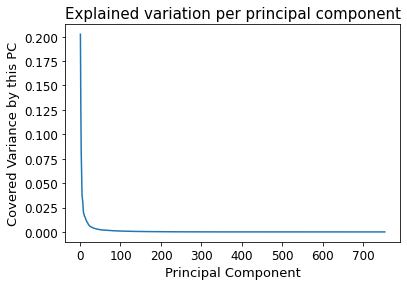

In [6]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)

X_train_transformed = pca.fit_transform(X_train_SMOTE)
X_test_transformed = pca.transform(X_test)

n = np.arange(1, len(pca.explained_variance_ratio_)+1)

plt.figure()
plt.plot(n, pca.explained_variance_ratio_)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Principal Component',fontsize=13)
plt.ylabel('Covered Variance by this PC',fontsize=13)
plt.title("Explained variation per principal component",fontsize=15)
plt.show()

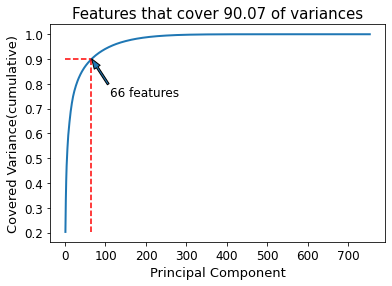

In [7]:
cumulative = np.cumsum(pca.explained_variance_ratio_)
i = 0
while cumulative[i] <0.9:
    i = i+1
val = cumulative[i]
index = i

n = np.arange(1 , len(pca.explained_variance_ratio_) + 1)
plt.plot(n , cumulative, lw=2)
plt.plot(np.arange(1 , index+1),np.full((index,1),val),'--' ,color='red')
plt.plot(np.full((index,1),index),np.linspace(cumulative[0],val,index),'--' , color='red')
plt.annotate(str(index+1)+' features', xy=(index+1 ,val), xytext=(110,0.75), arrowprops = dict(width=2 ,headlength=10 ,headwidth=7), fontsize=12)
plt.title('Features that cover '+ str(round(val*100,2))+' of variances',fontsize=15)
plt.xlabel('Principal Component',fontsize=13)
plt.ylabel('Covered Variance(cumulative)',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
pca1 = PCA(n_components=index+1, whiten=True)

X_train_transformed = pca1.fit_transform(X_train_SMOTE)
X_test_transformed = pca1.transform(X_test)

In [9]:
train_data = np.array(X_train_transformed)
train_labels = np.array(y_train_SMOTE)
test_data = np.array(X_test_transformed)
test_labels = np.array(y_test)

test_data.shape , train_data.shape

((227, 66), (780, 66))

## Evaluation Metrics

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluation(test_labels, predicted):
    confusion_mtx = confusion_matrix(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)
    f1score = f1_score(test_labels, predicted)
    report = classification_report(test_labels, predicted)

    FP = confusion_mtx.sum(axis=0) - np.diag(confusion_mtx)  
    FN = confusion_mtx.sum(axis=1) - np.diag(confusion_mtx)
    TP = np.diag(confusion_mtx)
    TN = confusion_mtx.sum() - (FP + FN + TP)
    
    recall = TP/(TP+FN)  # Sensitivity, hit rate, recall, or true positive rate   
    precision = TP/(TP+FP)  # Precision or positive predictive value
    
    print("Accuracy = {0:0.2f}".format(accuracy))
    print("Sensitivity = {0:0.2f}".format(recall[1]))
    print("Precision = {0:0.2f}".format(precision[1]))
    print("F1_score = {0:0.2f}".format(f1score))
    print('\n')
    print("Confusion matrix:\n%s" % confusion_mtx)

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_ROC(y_test, y_pred):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(5,3.5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=13)
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.title('Receiver Operating Characteristic',fontsize=14)
    plt.legend(loc="lower right",fontsize=12)
    plt.savefig('Log_ROC')
    plt.show()

## Logistic regression

Accuracy = 0.81
Sensitivity = 0.86
Precision = 0.89
F1_score = 0.87


Confusion matrix:
[[ 34  19]
 [ 25 149]]


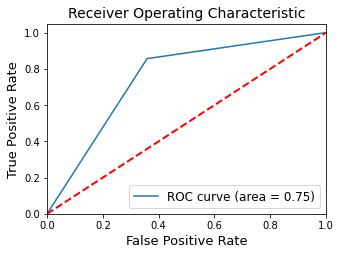

In [12]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## SVM

In [13]:
from sklearn import svm
#'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

### defferent kernel 

Accuracy = 0.89
Sensitivity = 0.97
Precision = 0.90
F1_score = 0.93


Confusion matrix:
[[ 34  19]
 [  6 168]]


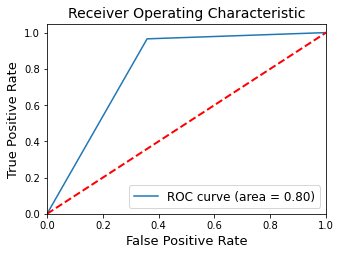

In [14]:
clf = svm.SVC(kernel='rbf')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.94
Sensitivity = 0.98
Precision = 0.94
F1_score = 0.96


Confusion matrix:
[[ 43  10]
 [  4 170]]


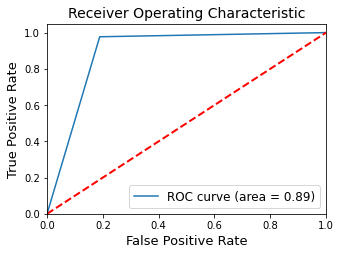

In [15]:
clf = svm.SVC(kernel='poly')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.81
Sensitivity = 0.86
Precision = 0.89
F1_score = 0.87


Confusion matrix:
[[ 35  18]
 [ 25 149]]


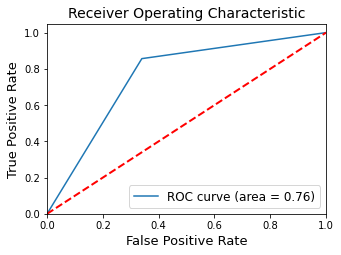

In [16]:
clf = svm.SVC(kernel='linear')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

##  Decision Tree

Accuracy = 0.75
Sensitivity = 0.79
Precision = 0.88
F1_score = 0.83


Confusion matrix:
[[ 34  19]
 [ 37 137]]


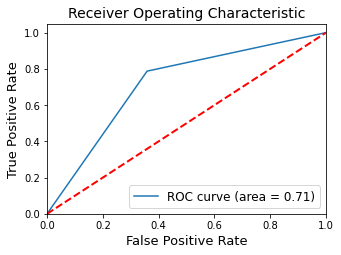

In [35]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## k-NN

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

different_k = np.array([1,2,3,4,5,6,7,8,9,10])

CCR_knn = []
for i in different_k:
    knn = KNeighborsClassifier(n_neighbors=i).fit(train_data, train_labels)
    predicted = knn.predict(test_data)
    CCR_knn.append(accuracy_score(test_labels, predicted))
    #print(i)
    #print(CCR_knn)

k_opt = different_k[CCR_knn.index(max(CCR_knn))]
print('k_opt =',k_opt)

k_opt = 1


Accuracy = 0.92
Sensitivity = 0.91
Precision = 0.98
F1_score = 0.95


Confusion matrix:
[[ 50   3]
 [ 15 159]]


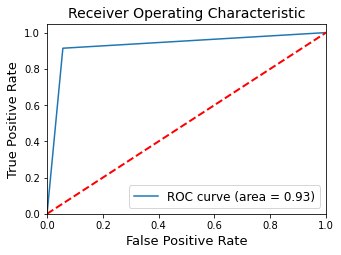

In [19]:
k = k_opt
knn = KNeighborsClassifier(n_neighbors=k_opt).fit(train_data, train_labels)
predicted = knn.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## GMM

In [20]:
from sklearn.mixture import GaussianMixture
# 'full', 'tied', 'diag', 'spherical'

### different covariance type

Accuracy = 0.72
Sensitivity = 0.94
Precision = 0.76
F1_score = 0.84


Confusion matrix:
[[  1  52]
 [ 11 163]]


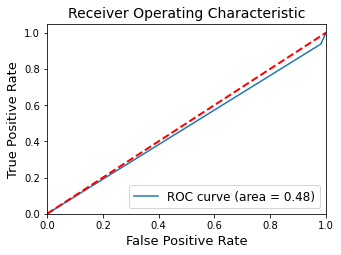

In [42]:
GMM = GaussianMixture(n_components=2, covariance_type='full').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.43
Sensitivity = 0.28
Precision = 0.92
F1_score = 0.42


Confusion matrix:
[[ 49   4]
 [126  48]]


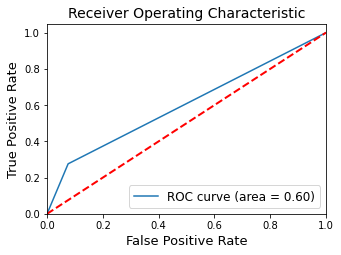

In [31]:
GMM = GaussianMixture(n_components=2, covariance_type='tied').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.64
Sensitivity = 0.77
Precision = 0.77
F1_score = 0.77


Confusion matrix:
[[ 12  41]
 [ 40 134]]


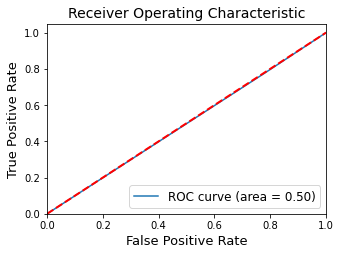

In [33]:
GMM = GaussianMixture(n_components=2, covariance_type='spherical').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## Parzen window

In [24]:
from sklearn.neighbors import KernelDensity
# 'gaussian'|'tophat'|'epanechnikov'|'exponential'|'linear'|'cosine'

In [25]:
classes = []
for i in range(0, 2):
    index = np.where(train_labels == i)[0]
    classes.append(train_data[index])

n = test_data.shape[0]
bandwidth = np.array([0.1,0.5,1,2,5,10]) 
accuracy = []
for i in bandwidth:
    kde0 = KernelDensity(bandwidth=i, kernel='gaussian')
    kde0 = kde0.fit(classes[0])
    logprob0 = kde0.score_samples(test_data)
    kde1 = KernelDensity(bandwidth=i, kernel='gaussian')
    kde1 = kde1.fit(classes[1])
    logprob1 = kde1.score_samples(test_data)
    predicted_labels = []
    for i in range (n):
        if np.exp(logprob0[i]) > np.exp(logprob1[i]):
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    CCR = np.sum(test_labels.T==predicted_labels)/len(predicted_labels)
    accuracy.append(CCR)
    
h_opt = bandwidth[accuracy.index(max(accuracy))]
print('h_opt =',h_opt)    

h_opt = 1.0


Accuracy = 0.89
Sensitivity = 0.90
Precision = 0.96
F1_score = 0.93


Confusion matrix:
[[ 46   7]
 [ 18 156]]


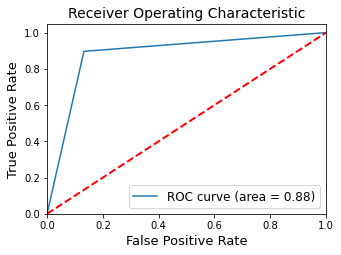

In [26]:
h = h_opt
kde0 = KernelDensity(bandwidth=h, kernel='gaussian').fit(classes[0])
logprob0 = kde0.score_samples(test_data)
kde1 = KernelDensity(bandwidth=h, kernel='gaussian').fit(classes[1])
logprob1 = kde1.score_samples(test_data)

predicted = []
for i in range (n):
    if np.exp(logprob0[i]) > np.exp(logprob1[i]):
        predicted.append(0)
    else:
        predicted.append(1)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)